## Contents
tutorials 
https://www.lucypark.kr/slides/2015-pyconkr/#66  
https://github.com/e9t/nsmc/  

[awesome-nlp](https://github.com/keon/awesome-nlp)
http://solarisailab.com/archives/374  
[syntaxnet](https://arxiv.org/pdf/1603.06042.pdf)  
https://github.com/tensorflow/models/tree/master/syntaxnet  
https://cpuu.postype.com/post/166917/
http://universaldependencies.org/  
https://github.com/tensorflow/models/tree/master/syntaxnet/syntaxnet/models/parsey_mcparseface  

In [5]:
DATASET_DIR = '/home/joo/Desktop/dataset/raw_dataset'
DATASET_DIR = DATASET_DIR + '/nsmc'

In [2]:
# jdk required
# pip3 install JPype1
# pip3 install konlpy
import konlpy
import gensim
import nltk
print(konlpy.__version__)
print(gensim.__version__)
print(nltk.__version__)

0.4.4
1.0.1
3.2.2


In [3]:
import jpype

### tutorials on Pycon 2015 : Basic Sentiment Analysis

In [6]:
def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]
        return data
train_data = read_data(DATASET_DIR+'/ratings_train.txt')
test_data = read_data(DATASET_DIR+'/ratings_test.txt')

In [7]:
print('num_rows : ', len(train_data))
print('num_cols : ', len(train_data[0])) # id comments rating
print('num_rows : ', len(test_data))
print('num_cols : ', len(test_data[0]))

num_rows :  150000
num_cols :  3
num_rows :  50000
num_cols :  3


In [8]:
from konlpy.tag import Twitter
pos_tagger = Twitter() # 품사
def tokenize(doc):
    return ['/'.join(t) for t in pos_tagger.pos(doc, norm=True, stem=True)]
train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
test_docs = [(tokenize(row[1]), row[2]) for row in test_data]

from pprint import pprint
pprint(train_docs[0])

(['아/Exclamation',
  '더빙/Noun',
  '../Punctuation',
  '진짜/Noun',
  '짜증/Noun',
  '나다/Verb',
  '목소리/Noun'],
 '0')


In [9]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

2194536


In [10]:
import nltk
text = nltk.Text(tokens, name='NMSC')
print(text)
print(len(text.tokens))
print(len(set(text.tokens)))
pprint(text.vocab().most_common(10))

<Text: NMSC>
2194536
48765
[('./Punctuation', 68630),
 ('영화/Noun', 51365),
 ('하다/Verb', 50281),
 ('이/Josa', 39123),
 ('보다/Verb', 34764),
 ('의/Josa', 30480),
 ('../Punctuation', 29055),
 ('에/Josa', 27108),
 ('가/Josa', 26696),
 ('을/Josa', 23481)]


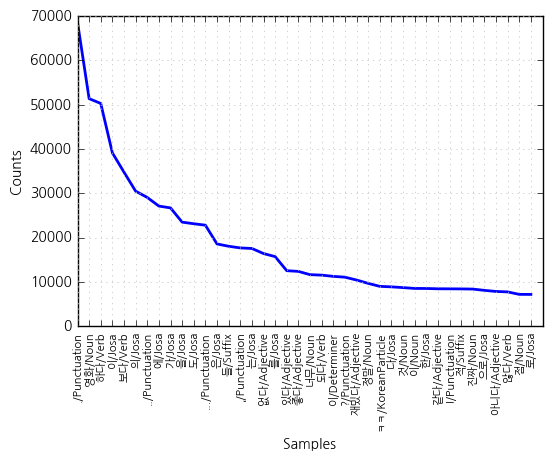

In [25]:
from matplotlib import font_manager, rc
import matplotlib as mpl
font_fname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'     # A font of your choice
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)
mpl.rcParams['xtick.labelsize'] = 8 
text.plot(40)

In [26]:
text.collocations()

이/Determiner 것/Noun; 적/Suffix 인/Josa; 이/Determiner 거/Noun; 안/Noun
되다/Verb; 것/Noun 은/Josa; 10/Number 점/Noun; 배우/Noun 들/Suffix; 수/Noun
있다/Adjective; 이/Noun 게/Josa; 내/Noun 가/Josa; 최고/Noun 의/Josa; 네/Suffix
요/Josa; 이/Noun 영화/Noun; 끝/Noun 까지/Josa; 들/Suffix 이/Josa; 봐/Noun
도/Josa; 때문/Noun 에/Josa; 적/Suffix 으로/Josa; 사람/Noun 들/Suffix; 영화/Noun
를/Josa


In [11]:
# Caution with memory
selected_words = [f[0] for f in text.vocab().most_common(20)]
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) 
            for word in selected_words}
train_docs = train_docs[:100]

In [12]:
train_xy = [(term_exists(d), c) for d, c in train_docs]
test_xy = [(term_exists(d), c) for d, c in test_docs]

In [16]:
classifier = nltk.NaiveBayesClassifier.train(train_xy)
print(nltk.classify.accuracy(classifier, test_xy))
classifier.show_most_informative_features(10)

0.56476
Most Informative Features
  exists(../Punctuation) = True                0 : 1      =      3.5 : 1.0
    exists(없다/Adjective) = True                0 : 1      =      2.8 : 1.0
    exists(좋다/Adjective) = True                1 : 0      =      2.6 : 1.0
    exists(있다/Adjective) = True                1 : 0      =      2.6 : 1.0
        exists(들/Suffix) = True                1 : 0      =      2.2 : 1.0
         exists(하다/Verb) = True                0 : 1      =      1.9 : 1.0
          exists(을/Josa) = True                1 : 0      =      1.9 : 1.0
          exists(를/Josa) = True                1 : 0      =      1.8 : 1.0
          exists(가/Josa) = True                1 : 0      =      1.8 : 1.0
          exists(이/Josa) = True                1 : 0      =      1.8 : 1.0


In [20]:
from collections import namedtuple
from gensim.models import doc2vec

In [21]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')

tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

In [22]:
doc_vectorizer = doc2vec.Doc2Vec(size=100, alpha=0.025, 
                                 min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(tagged_train_docs)

In [25]:
for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs, 
                         total_examples=doc_vectorizer.corpus_count, 
                         epochs=doc_vectorizer.iter)
    doc_vectorizer.alpha -= 0.002
    doc_vectorizer.min_alpha = doc_vectorizer.alpha

0.001

In [27]:
pprint(doc_vectorizer.most_similar('없다/Noun'))
pprint(doc_vectorizer.most_similar('있다/KoreanParticle'))
pprint(doc_vectorizer.most_similar(positive=['여자/Noun', '왕/Noun'],
                                  negative=['남자/Noun']))
text.concordance('왕/Noun', lines=10)

KeyError: "word '없다/Noun' not in vocabulary"

In [ ]:
train_x = [doc_vectorizer.infer_vector(doc.words) for doc 
           in tagged_train_docs]
train_y = [doc.tags[0] for doc in tagged_train_docs]
len(train_x)
len(train_x[0])
text_x = [doc_vectorizer.infer_vector(doc.words) for doc in tagge]